# Prelim

Dataset downloaded from : https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_unsorted_10k

Data is available at `s3://fh-pi-setty-m-eco-public/single-cell-primers/multiome/`

ArchR preprocessing script: https://github.com/settylab/single-cell-primers/blob/main/scripts/PBMC-mulitome-ATAC-ArchR-preprocessing.R

Review the notebook `PBMC-RNA-standalone.ipynb` for setup instructions.

In [1]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import palantir 
import phenograph
import harmony

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [4]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [5]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr

In [26]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc

def _dot_func(x, y):
    return x.dot(y)

def imputation_weights(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)
        
    ad.obsp['ImputeWeights'] = T_steps

def impute_data_with_weights(ad, data):
    res = _dot_func(ad.obsp['ImputeWeights'], data)
    return pd.DataFrame(res, index=ad.obs_names, columns=data.columns)
    


# Load data

## ATAC

In [6]:
data_dir = os.path.expanduser('data/multiome/ArchR/pbmc_multiome_atac/export/')

Load all the exported results from ArchR

### Peaks data

In [10]:
# Peaks data
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')

In [11]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()

,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,nearestGene,distToGeneStart,peakType,distToTSS,nearestTSS,GC,idx,N
chr1:817098-817598,chr1,817098,817598,501,*,23.02630,0.986,0.953,2,C3._.Rep2,FAM87B,23,Promoter,22,uc057aum.1,0.4830,1,0
chr1:826748-827248,chr1,826748,827248,501,*,4.43591,0.124,0.004,2,C12._.Rep1,LINC01128,1860,Exonic,165,uc057auo.1,0.6228,2,0
chr1:827315-827815,chr1,827315,827815,501,*,27.75370,0.982,0.944,2,C6._.Rep2,LINC01128,2427,Promoter,42,uc057auo.1,0.6966,3,0
chr1:844437-844937,chr1,844437,844937,501,*,9.74554,0.832,0.627,2,C10._.Rep2,LINC01128,19549,Intronic,6660,uc057auo.1,0.5150,4,0
chr1:857895-858395,chr1,857895,858395,501,*,6.78831,0.454,0.169,2,C17._.Rep1,LINC01128,33007,Exonic,6796,uc057auo.1,0.3792,5,0


In [12]:
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in peaks.columns:
    ad.var[col] = peaks[col]

<ipython-input-12-83fb4c701231>:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(counts.T)


In [13]:
ad.X = ad.X.tocsr()

In [14]:
ad

AnnData object with n_obs × n_vars = 11049 × 155406
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'

### SVD, UMAP and Metadata

In [15]:
# SVD
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

In [16]:
# UMAP
ad.obsm['X_umap_archr'] = pd.read_csv(data_dir + 'umap.csv', index_col=0).loc[ad.obs_names, : ].values

In [17]:
# Metadata
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values

In [18]:
ad

AnnData object with n_obs × n_vars = 11049 × 155406
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    obsm: 'X_svd', 'X_umap_archr'

### Gene scores

In [19]:
# Gene scores
scores = mmread(data_dir + 'gene_scores/scores.mtx')

In [20]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'gene_scores/cells.csv', index_col=0).iloc[:, 0]
genes = pd.read_csv(data_dir + 'gene_scores/genes.csv', index_col=0).iloc[:, 0]


In [42]:
ad.obsm['GeneScores'] = scores.T.tocsr()
ad.uns['GeneScoresColums'] = np.array(genes)

In [22]:
ad

AnnData object with n_obs × n_vars = 11049 × 155406
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums'
    obsm: 'X_svd', 'X_umap_archr', 'GeneScores'

### chromVAR

In [23]:
chromvar = pd.read_csv(data_dir + 'chromvar_motif_scores.csv', index_col=0)
chromvar

,pbmc_multiome#TCCCGGACACAAAGCG-1,pbmc_multiome#GAGAACCAGGGCTTTG-1,pbmc_multiome#TTAGGAACAGAGAGCC-1,pbmc_multiome#TGTGGCCAGTGATTCA-1,pbmc_multiome#GCCGTGAGTCAGTAAT-1,pbmc_multiome#AAGCGAATCAAAGGCA-1,pbmc_multiome#CTAGTAGGTCAACAAT-1,pbmc_multiome#AGCGGATAGTTTGGTA-1,pbmc_multiome#ACGGGAAGTTAAGCGC-1,pbmc_multiome#TGTATCCGTCACCAAA-1,...,pbmc_multiome#GTACCTTGTCCCGAAG-1,pbmc_multiome#GAAGGATGTCTAGCTT-1,pbmc_multiome#GCGGTTATCCTTAGTT-1,pbmc_multiome#TTCGTGCTCACTAGGT-1,pbmc_multiome#TGGTCAAGTAGTTACG-1,pbmc_multiome#GAAAGGCTCAGCATTA-1,pbmc_multiome#AGACTATGTGACATAT-1,pbmc_multiome#ACTTAGTCAGGTTCAC-1,pbmc_multiome#CTAACCCTCCTGGCTT-1,pbmc_multiome#CTAATGTCACCTACTT-1
TFAP2B_1,-1.988097,0.643295,0.864989,-1.078009,-0.226981,0.037719,-0.649050,-1.839236,-0.162712,-0.888784,...,0.607502,0.020848,1.345951,-1.174598,0.559266,0.470094,0.093237,0.753664,-0.981845,0.718342
TFAP2D_2,-0.339464,-1.260617,0.603400,-0.116325,-0.114905,0.564788,-0.537916,-0.466282,-0.673191,0.257397,...,0.765487,-1.335156,0.338681,1.034212,0.235381,-0.128850,0.302894,-0.005696,0.323667,-0.161049
TFAP2C_3,-3.386476,0.920939,0.958504,-0.041987,-1.786716,-1.691430,-1.648802,-0.370356,0.771833,-1.597393,...,-0.528684,1.844674,0.079887,-1.925377,-0.462146,-0.318611,0.568229,0.163597,-2.284992,-0.006398
TFAP2E_4,0.199432,-2.598482,-0.355986,0.806632,0.149988,-1.484315,-0.663724,-0.063307,-1.071377,0.507179,...,0.974937,0.339549,0.327382,0.218238,-1.522919,1.076833,1.155992,1.980963,-0.709396,-1.469401
TFAP2A_5,0.133848,-0.709443,-0.061314,-0.984815,-0.428313,0.653195,-0.411988,0.310523,2.077264,-0.400059,...,-1.451702,1.850827,-1.770130,0.034251,-0.110689,0.902568,1.449919,2.311090,0.013939,-0.922002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMAD5_866,0.052421,-0.552439,-0.976863,1.094055,1.188379,0.909129,1.048875,0.600305,-0.066049,0.035609,...,0.141565,0.772515,0.227284,-0.815188,0.661637,-1.093541,-0.480915,-1.149538,0.660764,0.212145
SMAD9_867,-1.543844,-0.952448,0.472045,-1.463356,-1.654489,-1.748838,-2.852440,-0.389118,-0.661892,-0.153246,...,-0.234954,-0.522991,1.611146,-1.751251,-0.169175,-0.892458,0.528437,-2.397558,0.177270,0.069969
SOX6_868,1.674380,-1.495935,-1.088669,-0.525997,2.081701,0.239861,-0.634843,-0.328946,-1.964970,0.056665,...,1.123963,3.022848,-0.399032,1.102890,0.048533,1.759048,0.063116,-0.793495,-0.292505,0.111234
TBX18_869,0.706324,1.021150,-0.755689,-0.641649,-0.519771,-0.154289,-0.514323,0.704184,-2.624390,1.690044,...,0.058430,0.884497,-0.643849,-0.966741,0.909063,0.495776,0.822759,-0.162857,-0.582932,-0.536348


In [24]:
ad.obsm['chromVAR'] = chromvar.T.loc[ad.obs_names, :]

In [25]:
ad

AnnData object with n_obs × n_vars = 11049 × 155406
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums'
    obsm: 'X_svd', 'X_umap_archr', 'GeneScores', 'chromVAR'

# Preprocessing

In [ ]:
# Diffusion maps using SVD
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_svd'], index=ad.obs_names))
ad.obsp['DM_Kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors'] = dm_res['EigenVectors'].values
ad.uns['DMEigenValues'] = dm_res['EigenValues'].values
ad

Determing nearest neighbor graph...


/home/msetty/.local/lib/python3.8/site-packages/palantir/utils.py:55: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


AnnData object with n_obs × n_vars = 11049 × 155406
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums', 'DMEigenValues'
    obsm: 'X_svd', 'X_umap_archr', 'GeneScores', 'chromVAR', 'DM_EigenVectors'
    obsp: 'DM_Kernel'

In [ ]:
# Imputation weights
imputation_weights(dm_res, ad)

# Visualizations

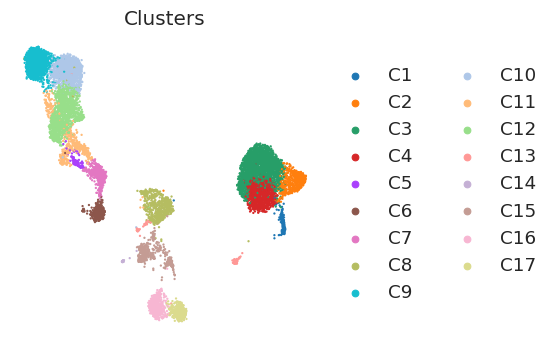

In [29]:
sc.pl.embedding(ad, basis='umap_archr', color='Clusters', frameon=False)

# Imputation examples

## Gene scores

In [30]:
gs_ad = sc.AnnData(ad.obsm['GeneScores'])
gs_ad.obs_names, gs_ad.var_names = ad.obs_names, ad.uns['GeneScoresColums']
gs_ad.obsm['X_umap'] = ad.obsm['X_umap_archr']

<ipython-input-30-375f55a70e64>:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  gs_ad = sc.AnnData(ad.obsm['GeneScores'])


In [31]:
genes = pd.Series([
    "CD34",  #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", "MS4A1", "MME", #B-Cell Trajectory
    "CD14",  #Monocytes
    "CD3D", "CD8A", 'CD4', #TCells,
    'FCGR3A', #'CD16', 
     'LEF1', 'NKG7', 'TREM1', 'LYZ', 'CD19',  'IRF8', 'IRF4',
    'ITGA2B', # CD41,
    'NCAM1', # CD56,
    'CCR7' # Memory T cell
])
genes = genes[genes.isin(ad.uns['GeneScoresColums'])]

In [32]:
# Create a dense matrix with interesting genes
data = pd.DataFrame(gs_ad[:, genes].X.todense(), index=gs_ad.obs_names, columns=genes)
# Impute
imputed_data = impute_data_with_weights(ad, data)

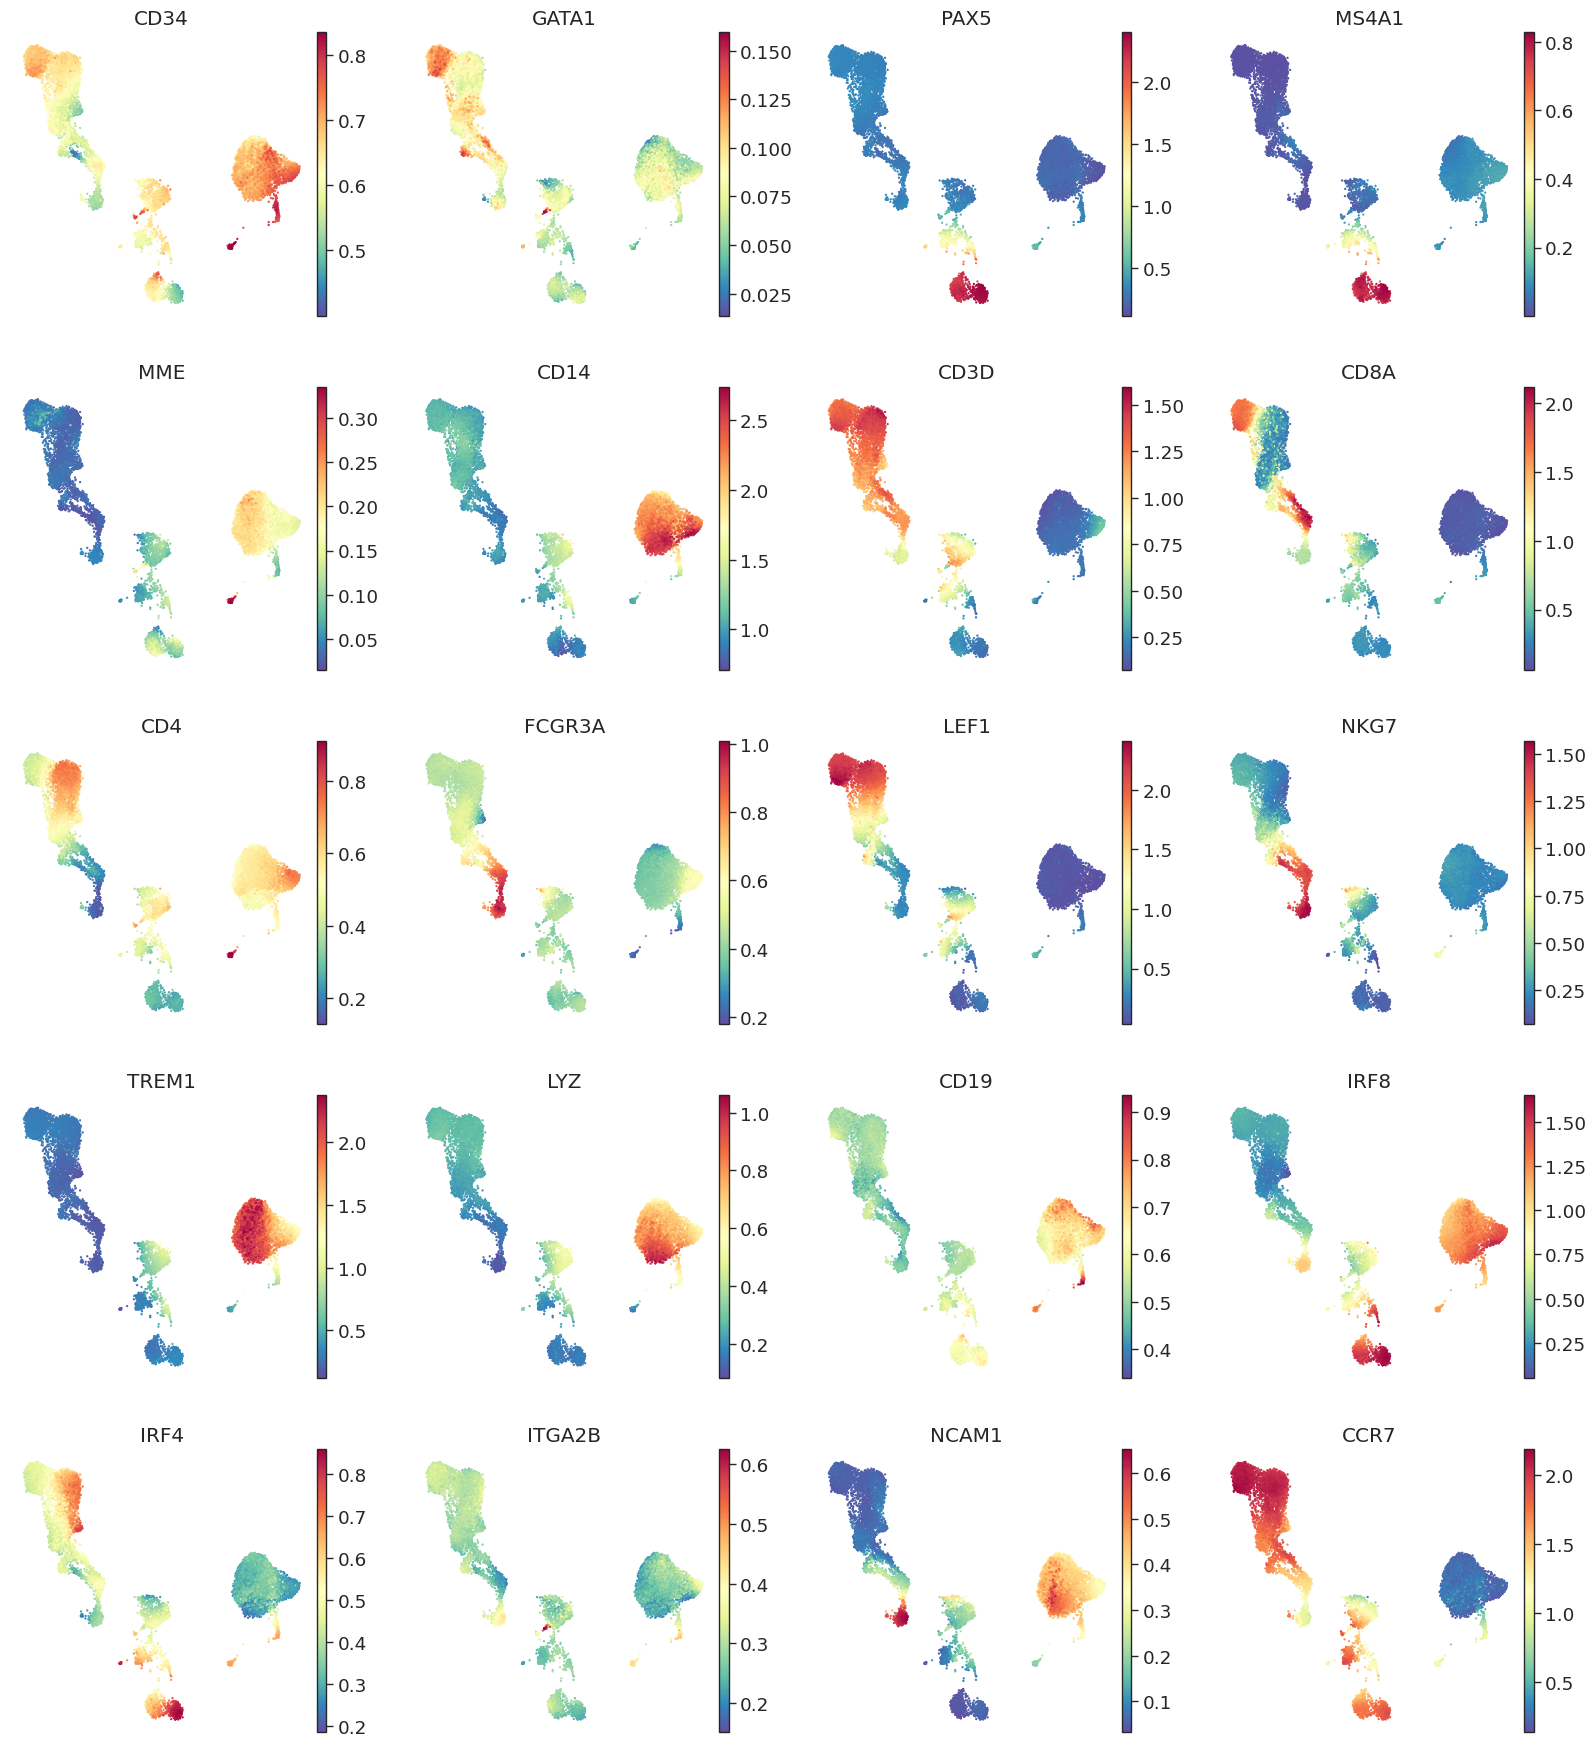

In [33]:
# Plot
temp = gs_ad[:, genes]
temp.layers['Imputed'] = imputed_data

sc.pl.embedding(temp, basis='umap', color=genes, layer='Imputed', frameon=False)

## ChromVAR

In [34]:
chromvar_ad = sc.AnnData(ad.obsm['chromVAR'])
chromvar_ad.obsm['X_umap'] = ad.obsm['X_umap_archr']

<ipython-input-34-c5f868350723>:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  chromvar_ad = sc.AnnData(ad.obsm['chromVAR'])


In [35]:
# We will use all motifs since total < 1000
# Impute
data = pd.DataFrame(chromvar_ad.X, index=chromvar_ad.obs_names, columns=chromvar_ad.var_names)
chromvar_ad.layers['Imputed'] = impute_data_with_weights(ad, data)

In [36]:
chromvar_ad.var_names[chromvar_ad.var_names.str.contains('GATA|PAX')]

Index(['GATA1_383', 'GATA3_384', 'GATA5_385', 'GATA4_386', 'GATA6_387',
       'GATA2_388', 'PAX6_604', 'PAX7_605', 'PAX2_606', 'PAX4_607', 'PAX3_608',
       'PAX8_707', 'PAX1_708', 'PAX5_709', 'PAX9_710'],
      dtype='object')

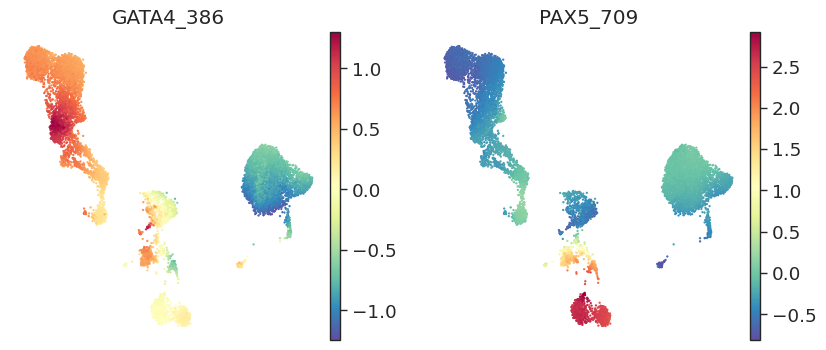

In [37]:
genes = ['GATA4_386', 'PAX5_709']
sc.pl.embedding(chromvar_ad, basis='umap', color=genes, layer='Imputed', frameon=False)

# Save

In [39]:
ad

AnnData object with n_obs × n_vars = 11049 × 155406
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums', 'DMEigenValues', 'Clusters_colors'
    obsm: 'X_svd', 'X_umap_archr', 'GeneScores', 'chromVAR', 'DM_EigenVectors'
    obsp: 'DM_Kernel', 'ImputeWeights'

In [43]:
ad.write(data_dir + '../../../pbmc_multiome_atac.h5ad')

In [44]:
data_dir

'../ArchR/pbmc_multiome_atac/export/'